# Tick Tick Bloom: Harmful Algal Bloom Detection Challenge

Inland water bodies provide a variety of critical services for both human and aquatic life, including drinking water, recreational and economic opportunities, and marine habitats. A significant challenge water quality managers face is the formation of harmful algal blooms (HABs). One of the major types of HABs is cyanobacteria. HABs produce toxins that are poisonous to humans and their pets, and threaten marine ecosystems by blocking sunlight and oxygen. Manual water sampling, or “in situ” sampling, is generally used to monitor cyanobacteria in inland water bodies. In situ sampling is accurate, but time intensive and difficult to perform continuously.

Your goal in this challenge is to use satellite imagery to detect and classify the severity of cyanobacteria blooms in small, inland water bodies. The resulting algorithm will help water quality managers better allocate resources for in situ sampling, and make more informed decisions around public health warnings for critical resources like drinking water reservoirs. Ultimately, more accurate and more timely detection of algal blooms helps keep both the human and marine life that rely on these water bodies safe and healthy.

Competition End Date:
Feb. 17, 2023, 11:59 p.m. UTC

***
# Library Imports

## Import, authenticate, and initialize Google Earth Engine

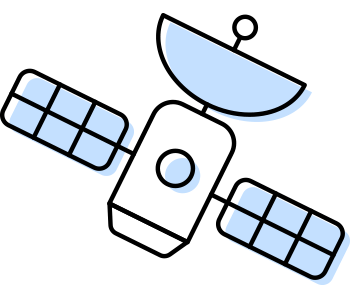

Import the API and run the ee.Authenticate function to authenticate your access to Earth Engine servers and ee.Initialize to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.


In [78]:
# Install ee_jupyter

try:
  import ee
  print('ee was already installed.')
except ModuleNotFoundError:
  print('ee was not found. Installing now...')
  import os
  result = os.system('conda install -c conda-forge earthengine-api')

ee was already installed.


In [79]:


import ee
ee.Authenticate()
ee.Initialize()
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

Enter verification code:  4/1AWtgzh7zpqrgteFCyQC-ZpPaeNpCopjIlVpOpCRqwuSuZnkrRUYlZ6iKpuc



Successfully saved authorization token.
NASADEM: NASA NASADEM Digital Elevation 30m


## Geemap

In [80]:
try:
  import ipyleaflet
  print('ipyleaflet was already installed.')
except ModuleNotFoundError:
  print('ipyleaflet was not found. Installing now...')
  import os
  result = os.system('pip -q install ipyleaflet')

ipyleaflet was already installed.


In [81]:
# Install geemap
try:
  import geemap
  print('geemap was already installed.')
except ModuleNotFoundError:
  print('geemap was not found. Installing now...')
  import os
  result = os.system('pip -q install geemap')
  result = os.system('conda install -c conda-forge ipyleaflet')


geemap was already installed.


## Using folium

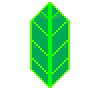

folium makes it easy to visualize data that’s been manipulated in Python on an interactive leaflet map. It enables both the binding of data to a map for choropleth visualizations as well as passing rich vector/raster/HTML visualizations as markers on the map.

In [82]:
# Install folium
try:
  import folium
  print('folium was already installed.')
except ModuleNotFoundError:
  print('folium was not found. Installing now...')
  import os
  result = os.system('pip -q install folium')

folium was already installed.


In [83]:
import folium
from IPython.display import Image

def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

## Spyndex

https://github.com/awesome-spectral-indices/spyndex

<img title="a title" alt="Alt text" src="https://raw.githubusercontent.com/davemlz/spyndex/main/docs/_static/spyndex.png" width="500">

The Awesome Spectral Indices is a standardized ready-to-use curated list of spectral indices that can be used as expressions for computing spectral indices in remote sensing applications. The list was born initially to supply spectral indices for Google Earth Engine through eemont and spectral, but given the necessity to compute spectral indices for other object classes outside the Earth Engine ecosystem, a new package was required.

Spyndex is a python package that uses the spectral indices from the Awesome Spectral Indices list and creates an expression evaluation method that is compatible with python object classes that support overloaded operators (e.g. numpy.ndarray, pandas.Series, xarray.DataArray).

Some of the spyndex features are listed here:

    Access to Spectral Indices from the Awesome Spectral Indices list.
    Multiple Spectral Indices computation.
    Kernel Indices computation.
    Parallel processing.
    Compatibility with a lot of python objects!








***
# Provided Data

## Metadata



Labels in this competition are based on “in situ” samples that were collected manually and then analyzed for cyanobacteria density. Each measurement is a unique combination of date and location (latitude and longitude). Samples come from water bodies throughout the continental U.S., and date back to 2013.

metadata.csv includes attributes for all of the sample measurements in the data. It has the following columns:

| Column name  | Date type    | Description                                                         |
|--------------|--------------|---------------------------------------------------------------------|
| uid          | str          | unique ID for each row                                              |
| latitude     | float        | latitude of the location where the sample was collected             |
| longitude    | float        | longitude of the location where the sample was collected            |
| date         | pd.datetime  | date when the sample was collected, in the format YYYY-MM-DD        |
| split        | str          | indicates whether the row is part of the train set or the test set  |


Metadata is provided for all points in both the train and test sets. Labels are only provided for rows in the train set.

In [84]:
import pandas as pd

# Import metadata 
metadata_df = pd.read_csv('./metadata.csv',
                          dtype = {'uid': str, 'latitude': float, 'longitude': float, 'date': str, 'split': str})

In [85]:
# Use the unique identifier as the index
metadata_df = metadata_df.set_index('uid')

# convert date to python datetime
metadata_df['py_date'] = metadata_df['date']
metadata_df['py_date'] = pd.to_datetime(metadata_df['py_date'])

# Make categorical for simpler use. https://pandas.pydata.org/docs/user_guide/categorical.html
metadata_df['split'] = metadata_df['split'].astype("category") 

# Add column for EE datetime
#metadata_df['date'] = metadata_df['date'].apply( lambda x : ee.Date(x) )

metadata_df.head()

latitude   longitude        date  split    py_date
uid                                                      
aabm  39.080319  -86.430867  2018-05-14  train 2018-05-14
aabn  36.559700 -121.510000  2016-08-31   test 2016-08-31
aacd  35.875083  -78.878434  2020-11-19  train 2020-11-19
aaee  35.487000  -79.062133  2016-08-24  train 2016-08-24
aaff  38.049471  -99.827001  2019-07-23  train 2019-07-23

What are the datatypes in the metadata_df?

In [86]:
metadata_df.dtypes

latitude            float64
longitude           float64
date                 object
split              category
py_date      datetime64[ns]
dtype: object

## Labels



The labels in this competition are samples that were collected manually and then analyzed for cyanobacteria density.

train_labels.csv includes the following columns:

| Column Name | Data type | Description |
|-------------|-----------|-------------|
| uid         | str       | unique ID for each row. Each row is a unique combination of date and location (latitude and longitude). uid maps each row of the labels to a row in metadata.csv.
| region      | str       | U.S. region in which the sample was taken. Scores are calculated separately for each of these regions and then averaged. See the metric section for details.
| severity    | int       | severity level based on the cyanobacteria density
| density     | float     | raw measurement of total cyanobacteria density in cells per mL. Participants should submit predictions for severity level, NOT for the raw cell density value in cells per milliliter (mL).


|severity level | Density range (cells/mL)  |
|---------------|---------------------------|
| 1             |             <20,000       |
| 2             | 20,000    — <100,000      |
| 3             | 100,000   — <1,000,000    | 
| 4             | 1,000,000 — <10,000,000   |
| 5             | ≥10,000,000               |



In [87]:
import pandas as pd

# Import metadata 
train_labels_df = pd.read_csv('./train_labels.csv')

# Use the unique identifier as the index
train_labels_df = train_labels_df.set_index('uid')

# Make categorical for simpler use. https://pandas.pydata.org/docs/user_guide/categorical.html
train_labels_df['severity'] = train_labels_df['severity'].astype("category") 

# Make categorical for simpler use. https://pandas.pydata.org/docs/user_guide/categorical.html
train_labels_df['region'] = train_labels_df['region'].astype("category") 

train_labels_df.head()

region severity    density
uid                              
aabm  midwest        1      585.0
aacd    south        1      290.0
aaee    south        1     1614.0
aaff  midwest        3   111825.0
aafl  midwest        4  2017313.0

## Combining metadata and labels into one big df



Rather than treating everything seperately, let's just combine our data into one big pandas frame, with the unknown values as NaNs.
This should give us a much better picture of the data we have right in front of us. 

In [131]:
df = pd.concat([metadata_df, train_labels_df],axis=1).reindex(metadata_df.index)

import datetime

df['end_date'] = df['date']
df['end_date'] = df['date'].apply(lambda x: datetime.datetime.strptime(row['date'], '%Y-%m-%d'))
df['end_date'] = df['end_date'].apply(lambda x: x.strftime('%Y-%m-%d'))

df['start_date'] = df['date']
df['start_date'] = df['start_date'].apply(lambda x: datetime.datetime.strptime(row['date'], '%Y-%m-%d'))
df['start_date'] = df['start_date'].apply(lambda x: x - datetime.timedelta(days=7))
df['start_date'] = df['start_date'].apply(lambda x: x.strftime('%Y-%m-%d'))

df

latitude   longitude       date  split    py_date   region severity  \
uid                                                                          
aabm  39.080319  -86.430867 2018-05-14  train 2018-05-14  midwest        1   
aabn  36.559700 -121.510000 2016-08-31   test 2016-08-31      NaN      NaN   
aacd  35.875083  -78.878434 2020-11-19  train 2020-11-19    south        1   
aaee  35.487000  -79.062133 2016-08-24  train 2016-08-24    south        1   
aaff  38.049471  -99.827001 2019-07-23  train 2019-07-23  midwest        3   
...         ...         ...        ...    ...        ...      ...      ...   
zzvv  36.708500 -121.749000 2014-12-02   test 2014-12-02      NaN      NaN   
zzwo  39.792190  -99.971050 2017-06-19  train 2017-06-19  midwest        2   
zzwq  35.794000  -79.012551 2015-03-24  train 2015-03-24    south        1   
zzyb  35.742000  -79.238600 2016-11-21  train 2016-11-21    south        1   
zzzi  39.767323  -96.028617 2015-08-31   test 2015-08-31      NaN      NaN   

       density    end_date  start_date  
uid                                     
aabm     585.0  2019-07-23  2019-07-16  
aabn       NaN  2019-07-23  2019-07-16  
aacd     290.0  2019-07-23  2019-07-16  
aaee    1614.0  2019-07-23  2019-07-16  
aaff  111825.0  2019-07-23  2019-07-16  
...        ...         ...         ...  
zzvv       NaN  2019-07-23  2019-07-16  
zzwo   48510.0  2019-07-23  2019-07-16  
zzwq    1271.0  2019-07-23  2019-07-16  
zzyb    9682.0  2019-07-23  2019-07-16  
zzzi       NaN  2019-07-23  2019-07-16  

[23570 rows x 10 columns]

***
# Visualizing data

## Analyzing location data in metadata

Where are our data points, on a map?

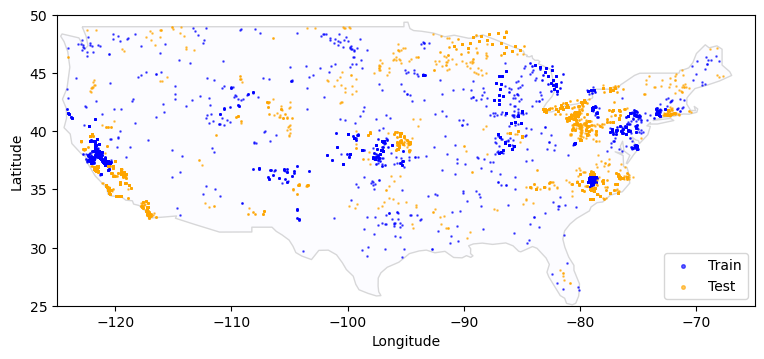

In [89]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# load the default geopandas base map file to plot points on
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(9, 4))

# map the training data
base = world[world.name == "United States of America"].plot(
    edgecolor="gray", color="ghostwhite", figsize=(9, 4), alpha=0.3, ax=ax
)
train_meta = metadata_df[metadata_df["split"] == "train"]
geometry = [Point(xy) for xy in zip(train_meta["longitude"], train_meta["latitude"])]
gdf = gpd.GeoDataFrame(train_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="blue", label="Train", alpha=0.6)

# map the test data
test_meta = metadata_df[metadata_df["split"] == "test"]
geometry = [Point(xy) for xy in zip(test_meta["longitude"], test_meta["latitude"])]
gdf = gpd.GeoDataFrame(test_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="orange", label="Test", alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=3)

The following piece of code attempts to plot all the data points on a folium map but it's *very* slow.

In [90]:
# # Define a map centered on San Francisco Bay.
# map_l8 = folium.Map(location=[37.5010, -122.1899], zoom_start=5)
# 
# # add marker one by one on the map
# for i in range(0,len(df)):
#     folium.Marker(
#       location=[df.iloc[i]['latitude'], df.iloc[i]['longitude']],
#       popup=df.iloc[i].name,
#    ).add_to(map_l8)
# 
# display(map_l8)

How is the data split between train and test?

In [91]:
# what is the date range?
metadata_df.date = pd.to_datetime(metadata_df.date) # convert date to pd.datetime
metadata_df.groupby("split").agg(min_date=("date", min), max_date=("date", max))

min_date   max_date
split                      
test  2013-01-08 2021-12-29
train 2013-01-04 2021-12-14

<AxesSubplot: title={'center': 'Number of train and split data points'}>

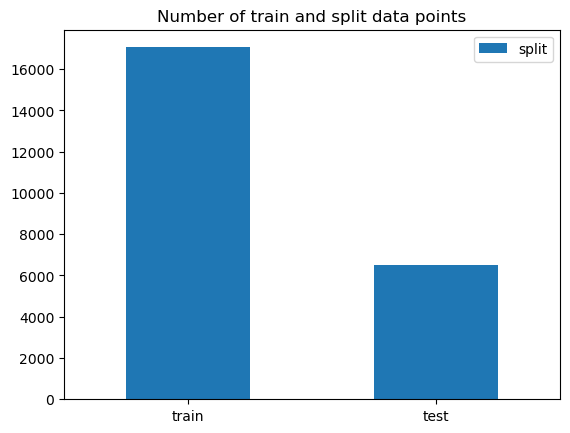

In [92]:
df.split.value_counts(dropna=False).plot.bar(rot=0,legend=True,title="Number of train and split data points")

How is the data split between different regions? 
(Tip: This is only for the training data, as we do not have these labels for the test data)

<img src="https://cdn.mappr.co/wp-content/uploads/2021/12/us-regions-map-census.jpg?w=2048&h=1365&scale.option=fill&cw=2048&ch=1365&cx=center&cy=center" width="400">


<AxesSubplot: title={'center': 'Number of train and split data points'}>

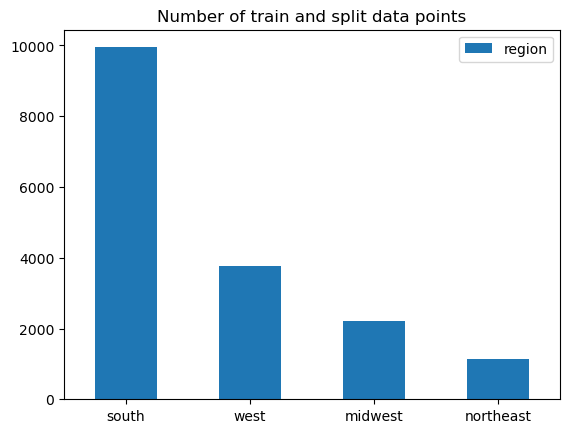

In [93]:
df.region.value_counts(dropna=True).plot.bar(rot=0,legend=True,title="Number of train and split data points")

How is the data split between different severity levels? 
(Tip: This is only for the training data, as we do not have these labels for the test data)


|severity level | Density range (cells/mL)  |
|---------------|---------------------------|
| 1             |             <20,000       |
| 2             | 20,000    — <100,000      |
| 3             | 100,000   — <1,000,000    | 
| 4             | 1,000,000 — <10,000,000   |
| 5             | ≥10,000,000               |

Recall that severity 1 is fine, while severity 2 and above are pretty bad.

<AxesSubplot: title={'center': 'Distribution of severity levels'}>

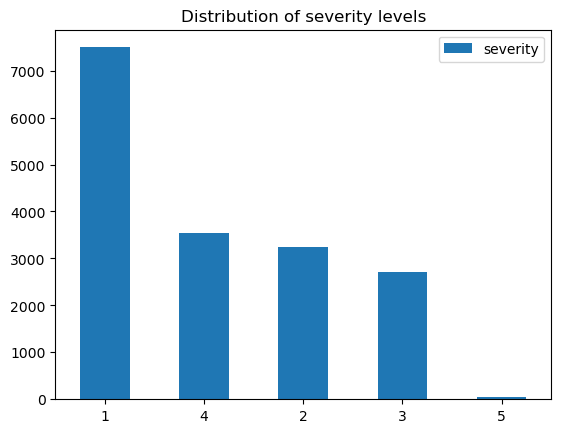

In [94]:
df.severity.value_counts(dropna=True).plot.bar(rot=0,legend=True,title="Distribution of severity levels")

How is our data split across time?

Text(0.5, 1.0, 'Distribution of years in the data')

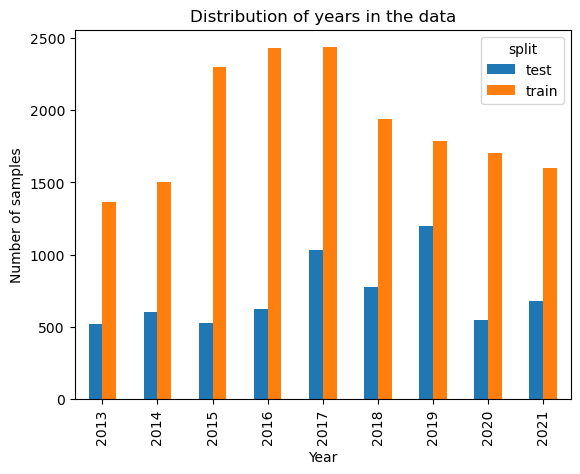

In [95]:
import matplotlib.pyplot as plt

#what years are in the data?
pd.crosstab(metadata_df.date.dt.year, metadata_df.split).plot(kind="bar")
plt.ylabel("Number of samples")
plt.xlabel("Year")
plt.title("Distribution of years in the data")

## Trying to plot a map of the train set on a folium map



First, let's use this boilerplate code to add Earth Engine images to a Folium map

In [96]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [97]:
import datetime
#Convert ee.Date to client-side date:

dayOfInterest = ee.Date('2019-01-01')
py_date = datetime.datetime.utcfromtimestamp(dayOfInterest.getInfo()['value']/1000.0)

py_date = py_date + datetime.timedelta(days=1)
dayOfInterest_plusone = ee.Date(py_date)
dayOfInterest_plusone

In [98]:
dayOfInterest = ee.Date('2018-05-14')

ffa_db = ee.Image(ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
                       .filterBounds(ee.Geometry.Point(-86.430867, 39.080319))
                       .filterDate(dayOfInterest, dayOfInterest_plusone)
                       .sort('CLOUDY_PIXEL_PERCENTAGE')
                       .first())
ffa_db

In [99]:
band_names = ffa_db.bandNames()
# print('Band names: ', band_names);

In [100]:
#print(ffa_db.bandNames())

In [104]:
# Make an RGB color composite image (VV,VH,VV/VH).
# rgb = ee.Image.rgb(ffa_db.select('VV'),
#                    ffa_db.select('VH'),
#                    ffa_db.select('VV').divide(ffa_db.select('VH')))

# map_s2 = folium.Map(location=[39.080319, -86.430867], zoom_start=11)

# Add the S1 rgb composite to the map object.
# map_s2.add_ee_layer(rgb, {'min': [-20, -20, 0], 'max': [0, 0, 2]}, 'FFA')

# Add a layer control panel to the map.
# map_s2.add_child(folium.LayerControl())

# Display the map.
# display(map_s2)


***
# Satellite Imagery data

In [165]:
from functools import partial

def size_ee_image_collection(col, row):
    START_DATE = row['start_date']
    END_DATE = row['end_date']
    AOI = ee.Geometry.Point(row['latitude'], row['longitude'])   
    return col.filterBounds(AOI).filterDate(START_DATE, END_DATE).size()

## Landsat

Landsat, a joint NASA/USGS program, provides the longest continuous space-based record of Earth’s land in existence.

There have been many Landsat missions since the original launch in 1972. The competition data only goes back to 2013, so participants should only use Landsat 8 and Landsat 9. Participants may not use any previous Landsat missions. Landsat 8 and Landsat 9 satellites are out of phase with one another, so that between the two each point on the Earth is revisited every 8 days. The data collected by Landsat 9 is very similar to Landsat 8.

### Landsat 8 - Surface Reflectance



Landsat 8 OLI/TIRS Collection 2 atmospherically corrected surface reflectance.
Dataset Availability: April 2013–Present

| Name  | Wavelength     | Description                                              |
|-------|----------------|----------------------------------------------------------|
| SR_B1 | 0.435-0.451 μm | Band 1 (ultra blue, coastal aerosol) surface reflectance |
| SR_B2 | 0.452-0.512 μm | Band 2 (blue) surface reflectance                        |
| SR_B3 | 0.533-0.590 μm | Band 3 (green) surface reflectance                       |
| SR_B4 | 0.636-0.673 μm | Band 4 (red) surface reflectance                         |
| SR_B5 | 0.851-0.879 μm | Band 5 (near infrared) surface reflectance               |
| SR_B6 | 1.566-1.651 μm | Band 6 (shortwave infrared 1) surface reflectance        |
| SR_B7 | 2.107-2.294 μm | Band 7 (shortwave infrared 2) surface reflectance        |


This dataset contains atmospherically corrected surface reflectance and land surface temperature derived from the data produced by the Landsat 8 OLI/TIRS sensors. These images contain 5 visible and near-infrared (VNIR) bands and 2 short-wave infrared (SWIR) bands processed to orthorectified surface reflectance, and one thermal infrared (TIR) band processed to orthorectified surface temperature. They also contain intermediate bands used in calculation of the ST products, as well as QA bands.

Landsat 8 SR products are created with the Land Surface Reflectance Code (LaSRC). All Collection 2 ST products are created with a single-channel algorithm jointly created by the Rochester Institute of Technology (RIT) and National Aeronautics and Space Administration (NASA) Jet Propulsion Laboratory (JPL).

In [148]:
# Create a default map
import geemap
Map = geemap.Map()


ROW_NUMBER = 5700
START_DATE = df.iloc[ROW_NUMBER]['start_date']
END_DATE = df.iloc[ROW_NUMBER]['end_date']
AOI = ee.Geometry.Point(
    df.iloc[ROW_NUMBER]['latitude'], 
    df.iloc[ROW_NUMBER]['longitude'])


col = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(AOI).filterDate(START_DATE, END_DATE)
if col.size() != 0:
    image = col.mosaic()

    # Define the visualization parameters.
    image_viz_params = {
        'bands': ['B2', 'B3', 'B4'],
        'min': 0,
        'max': 0.5,
        'gamma': [0.95, 1.1, 1]
    }

    # Center the map and display the image.
    Map.setCenter(df.iloc[ROW_NUMBER]['longitude'], df.iloc[ROW_NUMBER]['latitude'], 12) # San Francisco Bay
    Map.addLayer(image, vizParams, 'false color composite')


# Display the map
Map

Map(center=[35.036, -79.1189819350572], controls=(WidgetControl(options=['position', 'transparent_bg'], widget…

### Landsat 8 - Top of Atmosphere
Landsat 8 OLI/TIRS Collection 2 calibrated top-of-atmosphere (TOA) reflectance.
Dataset Availability: April 2013–Present

Landsat 8 Collection 2 Tier 1 calibrated top-of-atmosphere (TOA) reflectance. Calibration coefficients are extracted from the image metadata. See Chander et al. (2009) for details on the TOA computation.

Landsat scenes with the highest available data quality are placed into Tier 1 and are considered suitable for time-series processing analysis. Tier 1 includes Level-1 Precision Terrain (L1TP) processed data that have well-characterized radiometry and are inter-calibrated across the different Landsat sensors. The georegistration of Tier 1 scenes will be consistent and within prescribed tolerances [<=12 m root mean square error (RMSE)]. All Tier 1 Landsat data can be considered consistent and inter-calibrated (regardless of sensor) across the full collection. See more information in the USGS docs.

Landsat 8 Collection 2 Tier 2 calibrated top-of-atmosphere (TOA) reflectance. Calibration coefficients are extracted from the image metadata. See Chander et al. (2009) for details on the TOA computation. Scenes not meeting Tier 1 criteria during processing are assigned to Tier 2. This includes Systematic terrain (L1GT) and Systematic (L1GS) processed scenes, as well as any L1TP scenes that do not meet the Tier 1 specifications due to significant cloud cover, insufficient ground control, and other factors. Users interested in Tier 2 scenes can analyze the RMSE and other properties to determine the suitability for use in individual applications and studies. See more information in the USGS docs.

The T1_RT collection contains both Tier 1 and Real-Time (RT) assets. Newly-acquired Landsat 7 ETM+ and Landsat 8 OLI/TIRS data are processed upon downlink but use predicted ephemeris, initial bumper mode parameters, or initial TIRS line of sight model parameters. The data is placed in the Real-Time tier and made available for immediate download. Once the data have been reprocessed with definitive ephemeris, updated bumper mode parameters and refined TIRS parameters, the products are transitioned to either Tier 1 or Tier 2 and removed from the Real-Time tier. The transition delay from Real-Time to Tier 1 or Tier 2 is between 14 and 26 days.




In [176]:
#Landsat 8 OLI-2/TIRS-2, Surface Reflectance, Collection 2, Tier 1, atmospherically corrected surface reflectance.
col_landsat8_toa = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
size_landsat8_toa = partial(size_ee_image_collection, col_landsat8_toa)

In [199]:
# Generate result using pandas
result = []
for index, row in df.iterrows():
    START_DATE = row['start_date']
    END_DATE = row['end_date']
    AOI = ee.Geometry.Point(row['latitude'], row['longitude'])   
    result.append(col.filterBounds(AOI).filterDate(START_DATE, END_DATE).size().getInfo())
    
df["landsat8_toa"] = result

KeyboardInterrupt: 

In [ ]:
df[df["landsat8_toa"] != 0]

In [152]:
# Create a default map
import geemap
Map = geemap.Map()


ROW_NUMBER = 15762
START_DATE = df.iloc[ROW_NUMBER]['start_date']
END_DATE = df.iloc[ROW_NUMBER]['end_date']
AOI = ee.Geometry.Point(
    df.iloc[ROW_NUMBER]['latitude'], 
    df.iloc[ROW_NUMBER]['longitude'])


col = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA").filterBounds(AOI).filterDate(START_DATE, END_DATE)
if col.size() != 0:
    image = col.mosaic()

    # Define the visualization parameters.
    image_viz_params = {
        'bands': ['B2', 'B3', 'B4'],
        'min': 0,
        'max': 0.5,
        'gamma': [0.95, 1.1, 1]
    }

    # Center the map and display the image.
    Map.setCenter(df.iloc[ROW_NUMBER]['longitude'], df.iloc[ROW_NUMBER]['latitude'], 12) # San Francisco Bay
    Map.addLayer(image, vizParams, 'false color composite')


# Display the map
Map

Map(center=[35.6360586279262, -79.2934835776752], controls=(WidgetControl(options=['position', 'transparent_bg…

## Sentinel 2

[Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#description)

Sentinel-2 (S2) is a wide-swath, high-resolution, multispectral imaging mission with a global 5-day revisit frequency. The S2 Multispectral Instrument (MSI) samples 13 spectral bands: visible and NIR at 10 meters, red edge and SWIR at 20 meters, and atmospheric bands at 60 meters spatial resolution. It provides data suitable for assessing state and change of vegetation, soil, and water cover.


Sentinel-2 L2A also includes algorithmic bands that describe environmental features relevant to the behavior of algal blooms.

- Scene classification (SCL): The scene classification band sorts pixels into categories including water, high cloud probability, medium cloud probability, and vegetation. Water pixels could be used to calculate the size of a given water body, which impacts the behavior of blooms. Vegetation can indicate non-toxic marine life like sea grass that sometimes resembles cyanobacteria.

- Cloud masks (CLM): Sentinel-2’s cloud bands can be used to filter out cloudy pixels. Pixels that are obscured by clouds are likely not helpful for algal bloom detection because the actual water surface is not captured.

|Name | Scale | Pixel Size | Wavelength| Description |
|-----|-------|------------|-----------|-------------|
|B1 | 0.0001|60 meters|443.9nm |Aerosols|
|B2|0.0001 |10 meters|496.6nm  |Blue|
|B3|0.0001 |10 meters |560nm  |Green|
|B4 |0.0001|10 meters |664.5nm |Red|
|B5 |0.0001|20 meters|703.9nm |Red Edge 1|
|B6 |0.0001|20 meters|740.2nm |Red Edge 2|
|B7 |0.0001|20 meters |782.5nm  |Red Edge 3|
|B8 |0.0001 |10 meters |835.1nm  |NIR|
|B8A |0.0001 |20 meters |864.8nm |Red Edge 4|
|B9 |0.0001|60 meters|945nm |Water vapor|
|B11 |0.0001 |20 meters|1613.7nm |SWIR 1|
|B12 |0.0001 |20 meters |2202.4nm |SWIR 2|
|AOT |0.001 |10 meters||Aerosol Optical Thickness|
|WVP |0.001 |10 meters||Water Vapor Pressure in cm. The height the water would occupy if the vapor were condensed into liquid and spread evenly across the column.|
|SCL||20 meters ||Scene Classification Map. Min of 1 and max of 11. The "No Data" value of 0 is masked out.|
|TCI_R ||10 meters||True Color Image, Red channel|
|TCI_G||10 meters ||True Color Image, Green channel|
|TCI_B ||10 meters ||True Color Image, Blue channel|
|MSK_CLDPRB ||20 meters||Cloud Probability Map. Min of 0. Max of 100. (missing in some products)|
|MSK_SNWPRB ||10 meters||Snow Probability Map Min of 0. Max of 100. (missing in some products)|
|QA10 ||10 meters ||Always empty|
|QA20 ||20 meters||Always empty|
|QA60||60 meters||Cloud mask|

- L2A Surface Reflectance: Level-2A orthorectified atmospherically corrected surface reflectance. Dataset availability: 2017-03-28 – Present

      ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")



In [106]:
AOI = ee.Geometry.Point(-122.269, 45.701)
AOI_region = AOI.buffer(5000).bounds().getInfo()['coordinates']
START_DATE = '2020-06-01'
END_DATE = '2020-06-02'

img = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(AOI).filterDate(START_DATE, END_DATE).mosaic()
img

- L1C Top-of-Atmosphere Reflectance: Level-1C orthorectified top-of-atmosphere reflectance. Dataset availability: 2015-06-23 – Present
  
      ee.ImageCollection("COPERNICUS/S2_HARMONIZED") 

In [107]:
AOI = ee.Geometry.Point(-122.269, 45.701)
AOI_region = AOI.buffer(5000).bounds().getInfo()['coordinates']
START_DATE = '2020-06-01'
END_DATE = '2020-06-02'

img = ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filterBounds(AOI).filterDate(START_DATE, END_DATE).mosaic()

In [108]:
# Import the folium library.
import folium

# Define a method for displaying Earth Engine image tiles to a folium map.
def add_ee_layer(self, ee_image_object, vis_params, name, show=True, opacity=1, min_zoom=0):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        show=show,
        opacity=opacity,
        min_zoom=min_zoom,
        overlay=True,
        control=True
        ).add_to(self)

# Add the Earth Engine layer method to folium.
folium.Map.add_ee_layer = add_ee_layer

***
# All Commands

In [ ]:
from functools import partial

def size_ee_image_collection(col, row):
    START_DATE = row['start_date']
    END_DATE = row['end_date']
    AOI = ee.Geometry.Point(row['latitude'], row['longitude'])   
    return col.filterBounds(AOI).filterDate(START_DATE, END_DATE).size()

In [136]:
AOI = ee.Geometry.Point(-122.269, 45.701)
START_DATE = '2020-06-01'
END_DATE = '2020-06-02'



#Landsat 8 OLI-2/TIRS-2, Surface Reflectance, Collection 2, Tier 1, atmospherically corrected surface reflectance.
col_landsat8_toa = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(AOI).filterDate(START_DATE, END_DATE).mosaic()
size_landsat8_toa = partial(size_ee_image_collection, col_landsat8_toa)

#Landsat 8 OLI-2/TIRS-2, TOA Reflectance,  Collection 2 Tier 1, calibrated top-of-atmosphere (TOA) reflectance
ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA").filterBounds(AOI).filterDate(START_DATE, END_DATE).mosaic()

#Landsat 8 OLI-2/TIRS-2, TOA Reflectance,  Collection 2 Tier 1, scaled, calibrated at-sensor radiance.
ee.ImageCollection("LANDSAT/LC08/C02/T1").filterBounds(AOI).filterDate(START_DATE, END_DATE).mosaic()



#Landsat 9 OLI-2/TIRS-2, Surface Reflectance, Collection 2, Tier 1, atmospherically corrected surface reflectance.
ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(AOI).filterDate(START_DATE, END_DATE).mosaic()

#Landsat 9 OLI-2/TIRS-2, TOA Reflectance,  Collection 2 Tier 1, calibrated top-of-atmosphere (TOA) reflectance
ee.ImageCollection("LANDSAT/LC09/C02/T1_TOA").filterBounds(AOI).filterDate(START_DATE, END_DATE).mosaic()

#Landsat 9 OLI-2/TIRS-2, TOA Reflectance,  Collection 2 Tier 1, scaled, calibrated at-sensor radiance.
ee.ImageCollection("LANDSAT/LC09/C02/T1").filterBounds(AOI).filterDate(START_DATE, END_DATE).mosaic()



# Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A, Surface Reflectance
ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(AOI).filterDate(START_DATE, END_DATE).mosaic()

# Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-1C orthorectified top-of-atmosphere reflectance.
ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filterBounds(AOI).filterDate(START_DATE, END_DATE).mosaic()

In [ ]:
import geemap

In [139]:
# Create a default map
Map = geemap.Map()


ROW_NUMBER = 1
START_DATE = df.iloc[ROW_NUMBER]['start_date']
END_DATE = df.iloc[ROW_NUMBER]['end_date']
AOI = ee.Geometry.Point(
    df.iloc[ROW_NUMBER]['latitude'], 
    df.iloc[ROW_NUMBER]['longitude'])


col = ee.ImageCollection("LANDSAT/LC09/C02/T1").filterBounds(AOI).filterDate(START_DATE, END_DATE)
if col.size() != 0:
    image = col.mosaic()

    # Define the visualization parameters.
    image_viz_params = {
        'bands': ['B2', 'B3', 'B4'],
        'min': 0,
        'max': 0.5,
        'gamma': [0.95, 1.1, 1]
    }

    # Center the map and display the image.
    Map.setCenter(df.iloc[ROW_NUMBER]['longitude'], df.iloc[ROW_NUMBER]['latitude'], 8) # San Francisco Bay
    Map.addLayer(image, vizParams, 'false color composite')


# Display the map
Map

Map(center=[36.5597, -121.51], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

# Algal Bloom Detection via Spectral Index Thresholding

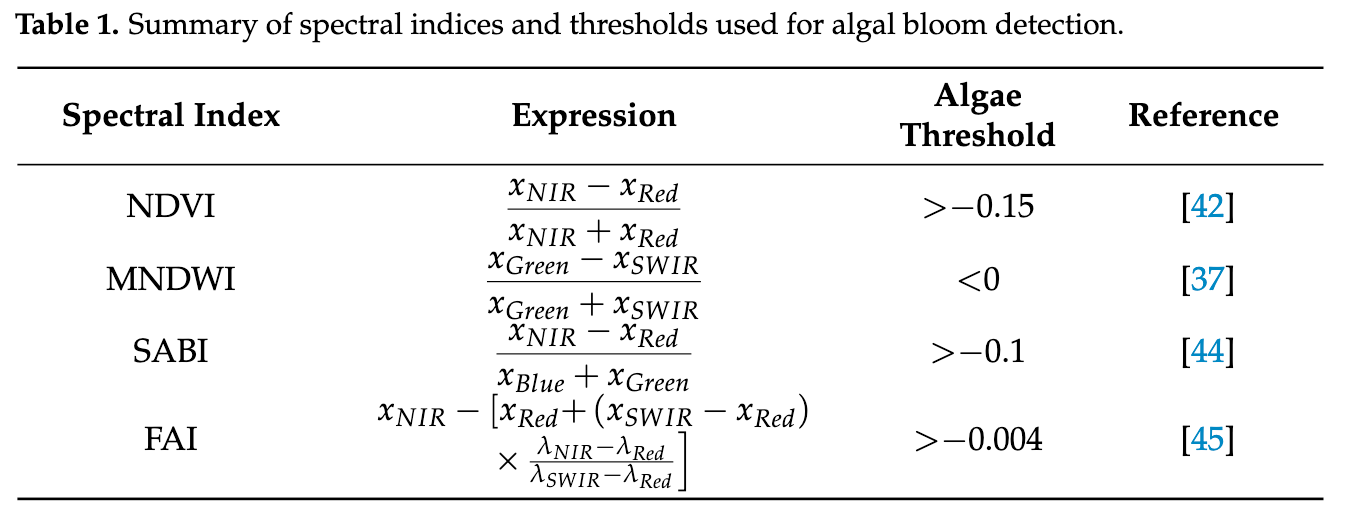

    ee.ImageCollection("COPERNICUS/S2_HARMONIZED")

From Sentinel 2
|Name | Scale | Pixel Size | Wavelength| Description |
|-----|-------|------------|-----------|-------------|
|B2|0.0001 |10 meters|496.6nm  |Blue|
|B3|0.0001 |10 meters |560nm  |Green|
|B4 |0.0001|10 meters |664.5nm |Red|
|B8 |0.0001 |10 meters |835.1nm  |NIR|
|B11 |0.0001 |20 meters|1613.7nm |SWIR 1|
|B12 |0.0001 |20 meters |2202.4nm |SWIR 2|

In [ ]:
AOI = ee.Geometry.Point(-122.269, 45.701)
START_DATE = '2020-06-01'
END_DATE = '2020-06-02'
s2_col_eval = get_s2_sr_col(AOI, START_DATE, END_DATE)
img = s2_col_eval.mosaic()

          
def scaleImage(img):
    scaling = img.select('B[1-7]')
    x = scaling.multiply(0.0001)
    scaling = img.select(['B10','B11'])
    scaling = scaling.multiply(0.1)
    x = x.addBands(scaling)
    notScaling = img.select([
        'sr_aerosol',
        'pixel_qa',
        'radsat_qa'
    ]))
    return x.addBands(notScaling)

def addIndices(img):
    x = ['B5','B4']
    a = img.normalizedDifference(x)
    a = a.rename('NDVI')
    x = ['B5','B3']
    b = img.normalizedDifference(x)
    b = b.rename('GNDVI')
    x = ['B3','B6']
    c = img.normalizedDifference(x)
    c = b.rename('NDSI')
    return img.addBands([a,b,c])                    

(ee.ImageCollection(ds)
    .map(scaleImage)
    .map(addIndices))


In [ ]:
df